# Final Project: Speaker-Aware Audio Classification

This notebook implements the classification phase using **Leave-One-Group-Out (LOGO)** cross-validation to prevent speaker leakage.

## Workflow overview:
1.  **Data Loading:** Load extracted features and labels.
2.  **Speaker Inference:** Unsupervised clustering to identify speaker groups.
3.  **Pipeline Selection:** Compare PCA, LDA, and PCA+LDA pipelines.
4.  **Model Tuning:** Tune SVC, GaussianNB, LogisticRegression, and RandomForest.
5.  **Final Output:** Save the best model.


In [81]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import warnings

from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')


## 1. Data Loading

We load the feature matrix `X.npy` and label array `y.npy` from the artifacts directory.


In [82]:
ARTIFACTS_DIR = Path("artifacts")

X = np.load(ARTIFACTS_DIR / "X.npy")
y = np.load(ARTIFACTS_DIR / "y.npy", allow_pickle=True)

print(X.shape)
print(y.shape)


(720, 952)
(720,)


### Label Encoding
Target labels are converted to integers.


In [83]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
classes = list(le.classes_)

print(classes)


[np.str_('German'), np.str_('Italian'), np.str_('Korean'), np.str_('Spanish')]


## 2. Speaker Inference (Clustering)

Since we do not have explicit speaker labels, we infer them.
We reduce dimensions to 50 using **PCA** and then apply **Agglomerative Clustering** to find **16 clusters** (representing 4 speakers per 4 languages).


In [84]:
pca_cluster = PCA(n_components=50, random_state=42)
X_reduced = pca_cluster.fit_transform(X)

agg = AgglomerativeClustering(n_clusters=16, metric='euclidean', linkage='ward')
groups = agg.fit_predict(X_reduced)

print(np.unique(groups))
print(pd.Series(groups).value_counts().sort_index())


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
0     50
1     98
2     53
3     61
4     53
5     40
6     59
7     29
8     15
9     38
10     7
11    46
12    60
13    30
14    66
15    15
Name: count, dtype: int64


## 3. Pipeline Selection

We define three specific preprocessing pipelines requested for analysis:
*   **PCA:** Standard Scaler $\rightarrow$ PCA (200 components)
*   **LDA:** Standard Scaler $\rightarrow$ LDA (3 components)
*   **PCA + LDA:** Standard Scaler $\rightarrow$ PCA (200) $\rightarrow$ LDA (3)

We evaluate them using **Leave-One-Group-Out (LOGO)** cross-validation to ensure speaker independence.


In [85]:
logo = LeaveOneGroupOut()

pipelines = {
    "PCA": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=200, random_state=42)),
        ("clf", LogisticRegression(max_iter=5000, n_jobs=-1, random_state=42))
    ]),
    "LDA": Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LDA(n_components=3)),
        ("clf", LogisticRegression(max_iter=5000, n_jobs=-1, random_state=42))
    ]),
    "PCA+LDA": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=200, random_state=42)),
        ("lda", LDA(n_components=3)),
        ("clf", LogisticRegression(max_iter=5000, n_jobs=-1, random_state=42))
    ])
}


In [86]:
results_pipe = []

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y_enc, groups=groups, cv=logo, scoring='f1_macro', n_jobs=-1)
    results_pipe.append({"pipeline": name, "f1_macro": np.mean(scores)})

df_results = pd.DataFrame(results_pipe).sort_values("f1_macro", ascending=False)
best_pipeline_name = df_results.iloc[0]["pipeline"]


In [87]:
print(best_pipeline_name)
print(df_results)


PCA+LDA
  pipeline  f1_macro
2  PCA+LDA  0.941707
0      PCA  0.926098
1      LDA  0.898952


## 4. Model Tuning

We use the **Best Pipeline** found in the previous step and freeze the preprocessing steps.
We then perform Hyperparameter Tuning for 4 models using `GridSearchCV` combined with `LeaveOneGroupOut`:

1.  **SVC**
2.  **GaussianNB**
3.  **LogisticRegression**
4.  **RandomForest**


In [88]:
def get_preprocessing(name):
    if name == "PCA":
        return [("scaler", StandardScaler()), ("pca", PCA(n_components=200, random_state=42))]
    elif name == "LDA":
        return [("scaler", StandardScaler()), ("lda", LDA(n_components=3))]
    elif name == "PCA+LDA":
        return [("scaler", StandardScaler()), ("pca", PCA(n_components=200, random_state=42)), ("lda", LDA(n_components=3))]

preprocess_steps = get_preprocessing(best_pipeline_name)

models_config = {
    "SVC": {
        "model": SVC(random_state=42),
        "params": {
            "clf__C": [1, 10],
            "clf__kernel": ["rbf"]
        }
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {} 
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=5000, n_jobs=-1, random_state=42),
        "params": {
            "clf__C": [0.1, 1, 10]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(n_jobs=-1, random_state=42),
        "params": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [10, 20]
        }
    }
}


In [ ]:
from sklearn.model_selection import cross_val_predict

final_results = []
best_estimators = {}

print("Starting Hyperparameter Tuning & CV Prediction...")

for name, config in models_config.items():
    full_pipeline = Pipeline(preprocess_steps + [("clf", config["model"])])
    
    grid = GridSearchCV(
        full_pipeline,
        config["params"],
        cv=logo,
        scoring='f1_macro',
        n_jobs=-1
    )
    
    grid.fit(X, y_enc, groups=groups)
    
    best_params = grid.best_params_
    best_score = grid.best_score_
    

    clean_pipeline = Pipeline(preprocess_steps + [("clf", config["model"])])
    clean_pipeline.set_params(**best_params)
    
    y_pred_cv = cross_val_predict(
        clean_pipeline,
        X,
        y_enc,
        groups=groups,
        cv=logo,
        n_jobs=-1
    )
    
    best_estimators[name] = grid.best_estimator_
    final_results.append({
        "Model": name,
        "LOGO F1 Score": best_score,
        "Best Params": best_params,
        "Predictions": y_pred_cv  
    })

df_final = pd.DataFrame(final_results).sort_values("LOGO F1 Score", ascending=False)
print(df_final[["Model", "LOGO F1 Score", "Best Params"]])


Starting Hyperparameter Tuning & CV Prediction...
                Model  LOGO F1 Score  \
2  LogisticRegression       0.943948   
1          GaussianNB       0.941707   
3        RandomForest       0.941707   
0                 SVC       0.918559   

                                        Best Params  
2                                    {'clf__C': 10}  
1                                                {}  
3  {'clf__max_depth': 10, 'clf__n_estimators': 200}  
0               {'clf__C': 1, 'clf__kernel': 'rbf'}  


Winner Model: LogisticRegression
Score (LOGO F1): 0.9439

--- Final Classification Report ---
              precision    recall  f1-score   support

      German       1.00      0.99      0.99       180
     Italian       0.99      0.97      0.98       180
      Korean       1.00      1.00      1.00       180
     Spanish       0.97      1.00      0.99       180

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



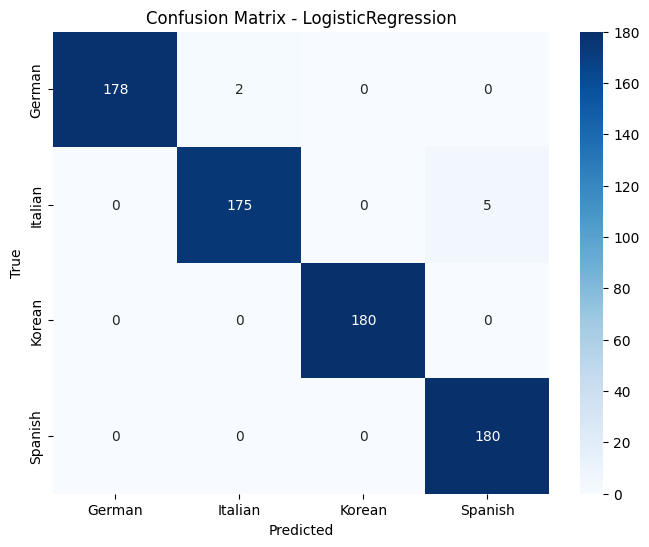

Best model saved to artifacts.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix

best_row = df_final.iloc[0]
best_model_name = best_row["Model"]
y_pred_final = best_row["Predictions"] 

print(f"Winner Model: {best_model_name}")
print(f"Score (LOGO F1): {best_row['LOGO F1 Score']:.4f}")

print("\n--- Final Classification Report ---")
print(classification_report(y_enc, y_pred_final, target_names=classes))

cm = confusion_matrix(y_enc, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

final_model_to_save = best_estimators[best_model_name]
joblib.dump(final_model_to_save, ARTIFACTS_DIR / "best_model_logo.joblib")

df_final_save = df_final.drop(columns=["Predictions"])
df_final_save.to_csv(ARTIFACTS_DIR / "final_results_logo.csv", index=False)

print("Best model saved to artifacts.")


## 5. Final Model Serialization

We select the model with the highest **LOGO F1 Score**.
The selected model is then re-fitted on the entire dataset to maximize learned patterns before saving to disk.


              precision    recall  f1-score   support

      German     1.0000    0.9889    0.9944       180
     Italian     0.9887    0.9722    0.9804       180
      Korean     1.0000    1.0000    1.0000       180
     Spanish     0.9730    1.0000    0.9863       180

    accuracy                         0.9903       720
   macro avg     0.9904    0.9903    0.9903       720
weighted avg     0.9904    0.9903    0.9903       720



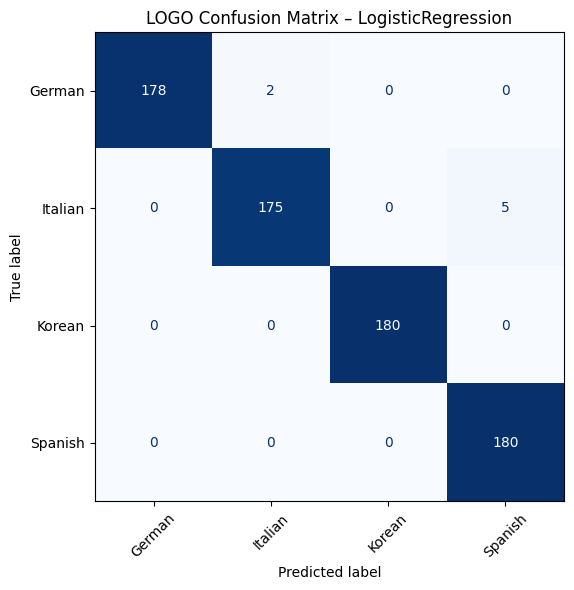

In [105]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logo_predictions = y_pred_clean                # already filled in your manual LOGO loop
logo_targets = y_enc

print(classification_report(
    logo_targets,
    logo_predictions,
    target_names=classes,
    digits=4
))

cm = confusion_matrix(logo_targets, logo_predictions, labels=np.arange(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title(f'LOGO Confusion Matrix – {best_model_name}')
plt.tight_layout()
plt.show()
